# Instant Neural Graphics Privmitives with a Multiresolution Hash Encoding

Original Paper: [Instant Neural Graphics Primitives with a Multiresolution Hash Encoding](https://arxiv.org/abs/2201.05989)

Instant-NGP introduces hash table of trainable features and uses it as input to small neural network so it can learn and infer density and colors of given coordinate. The features in the hash table contains the information in different resolution ( Adaptivity) and therefore, the reconstructed view of image can reach good quality and speedup of several orders of magnitude thanks to the parallelization process of hash table on modern GPUs (Efficiency). 

Traditionally, NeRF trains a fully connected neural network $m(x;\Phi)$ that has 5D coordinate ($x,y,z,\theta,\phi$) as input and output density $\sigma$, colors $RGB$ at that spatical location. Instant NGP trains two newtworks, one encode x to new inputs $y=enc(x;\theta)$ and feed the output y to smaller neural network $m(y;\Phi)$. 


In [3]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image

### Multiresolution encoding neural network $enc(x;\theta)$

![Hashtable](Illustration_hash_table.png)

In figure (1), The spatial hash function used in the paper is defined as:
$$ h(x)=(\oplus_{i=1}^{d}{x_i}{\pi_i})\quad mod \quad {T}
$$
In figure (3), torch.nn.functional.grid_sample is called to do linear interpolation

In [4]:
#Here is a demonstration code of the above figure
L=2
F=2
T=2**3
N_min=2
N_max=8
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]


#x = torch.tensor([[0.1,0.1],[0.4,0.4],[0.9,0.9]])
x = torch.tensor([[0.1,0.1]])
pi1, pi2 = 1, 2_654_435_761  #hash primes
lookup_tables = torch.nn.ParameterDict(
            {str(i): torch.nn.Parameter((torch.rand(
                (T, 2)) * 2 - 1) * 1e-4) for i in range(len(Nl))})
features = torch.empty((x.shape[0], F * len(Nl)))

for i, N in enumerate(Nl):
    # Computing vertices, use nn.functional.grid_sample convention
    #Step 1: scale input coordinate by the level's grid resolution before rounding down and up
    floor = torch.floor(x * N)
    ceil = torch.ceil(x * N)
    vertices = torch.zeros((x.shape[0], 4, 2), dtype=torch.int64, device=x.device)
    vertices[:, 0] = floor
    vertices[:, 1] = torch.cat((ceil[:, 0, None], floor[:, 1, None]), dim=1)
    vertices[:, 2] = torch.cat((floor[:, 0, None], ceil[:, 1, None]), dim=1)
    vertices[:, 3] = ceil

    # hashing: map each corner to an entry in the level's respective feature vector array
    a = vertices[:, :, 0] * pi1
    b = vertices[:, :, 1] * pi2
    h_x = torch.remainder(torch.bitwise_xor(a, b), T) #the table has fixed size of at most T

    # Lookup
    looked_up = lookup_tables[str(i)][h_x].transpose(-1, -2)
    volume = looked_up.reshape((looked_up.shape[0], 2, 2, 2))
    features[:, i*2:(i+1)*2] = torch.nn.functional.grid_sample(
        volume,
        ((x * N - floor) - 0.5).unsqueeze(1).unsqueeze(1)
        ).squeeze(-1).squeeze(-1)

/home/seawi/miniconda3/envs/gpu_env/lib/python3.13/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [5]:
for i, N in enumerate(Nl):
    print('Lookup table at resolution:',i,lookup_tables[str(i)])
print('features as new input to neural network:',features)

Lookup table at resolution: 0 Parameter containing:
tensor([[-3.8755e-05, -7.3787e-05],
        [ 6.5238e-05,  2.4374e-06],
        [-1.9208e-05, -4.7982e-05],
        [-4.5171e-05, -9.6610e-06],
        [-7.8387e-05,  1.5862e-05],
        [-4.1316e-05, -6.1907e-06],
        [-5.4709e-06,  4.1179e-05],
        [-3.4646e-05, -7.2978e-05]], requires_grad=True)
Lookup table at resolution: 1 Parameter containing:
tensor([[ 3.4751e-05, -5.2318e-05],
        [ 7.7580e-05,  9.5307e-05],
        [ 6.4077e-05, -3.0263e-05],
        [ 6.6521e-05,  4.0221e-05],
        [-8.9462e-05,  9.1051e-05],
        [ 6.2467e-05,  1.0428e-05],
        [-8.4499e-05,  4.1916e-05],
        [-6.3052e-06, -9.1370e-05]], requires_grad=True)
features as new input to neural network: tensor([[-5.4773e-06, -4.9395e-05,  5.2739e-05,  9.6845e-06]],
       grad_fn=<CopySlices>)


The hyper parameters used in the original paper for the scene (800x800) lego:

In [6]:
L = 16          #number of resolution level
F = 2           #number of feature dimenstions per entry vector
T = 2**19       #Maximum number of entries perlevel (hash table size)
N_min = 16      #coarsest resoltuion
N_max = 2048    #finest resoltuion is chosen to match the finest detail in the training data.
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]

Get to know the scenes that we try to learn:

In [7]:
training_dataset = torch.from_numpy(np.load('training_data_800x800.pkl',allow_pickle=True))
testing_dataset = torch.from_numpy(np.load('testing_data_800x800.pkl',allow_pickle=True))

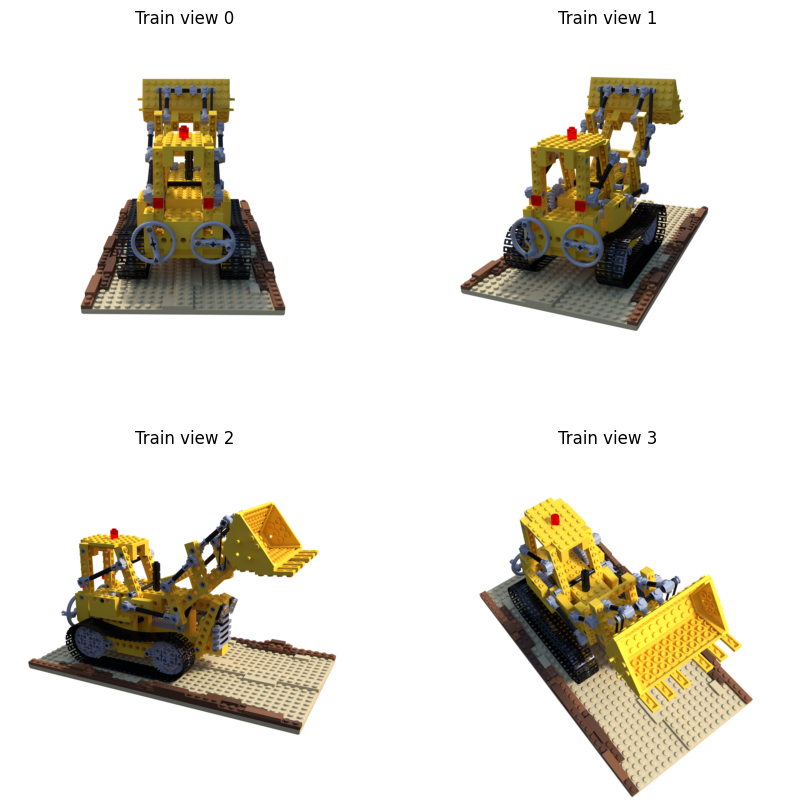

In [ ]:
import matplotlib.pyplot as plt

H, W=800, 800
fig, axes = plt.subplots(2,2, figsize=(10,10))
for i in range(4):
    img_data = training_dataset[i * H * W : (i + 1) * H * W, 6:]  
    img = img_data.reshape(H,W,3)
    axes[i//2, i%2].imshow(img)
    axes[i//2, i%2].set_title(f"Train view {i}")
    axes[i//2, i%2].axis('off')
plt.show()

The other parts of the algorithms are close to orginal NeRF (see NeRF_tutorial.ipynb for more detail). Here we load the model and test it 

In [ ]:
from ngp import NGP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load model to estimate density and color at 3D spatial position
model = NGP(T, Nl, 4, device, 3)
model.load_state_dict(torch.load('../models/ngp_model.pth', map_location=device))
model.eval()
model.to(device)

hn,hf=2,6
chunk_size=20
for img_index in range(2):
    ray_origins = testing_dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = testing_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    px_values = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        px_values.append(render_rays(model, ray_origins_, ray_directions_,
                                     hn=hn, hf=hf, nb_bins=nb_bins))
    img = torch.cat(px_values).data.cpu().numpy().reshape(H, W, 3)
    img = (img.clip(0, 1)*255.).astype(np.uint8)
    img_rendered = Image.fromarray(img)


    # Ground truth image from testing_dataset
    img_gt = testing_dataset[img_index * H * W : (img_index + 1) * H * W, 6:]
    img_gt = img_gt.reshape(H, W, 3)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_rendered)
    axes[0].set_title("Rendered Image")
    axes[0].axis('off')

    axes[1].imshow(img_gt)
    axes[1].set_title("Ground Truth Image")
    axes[1].axis('off')

    plt.show()